In [ ]:
import os 
import shutil

dataset_path = 'Amharic_Sign_Language'

print(os.listdir(dataset_path))

# create a folder for merged dataset
merged_dataset_path = os.path.join(dataset_path, 'merged_dataset')

if not os.path.exists(merged_dataset_path):
    os.mkdir(merged_dataset_path)

train_files = os.listdir(os.path.join(dataset_path, 'train'))
test_files = os.listdir(os.path.join(dataset_path, 'test'))

# moving train dataset to the merged dataset folder
for t_file in train_files:
    source = os.path.join(dataset_path, 'train', t_file)
    destination = os.path.join(merged_dataset_path, t_file)
    shutil.move(source, destination)

# moving test dataset to the merged dataset folder
for t_file in test_files:
    source = os.path.join(dataset_path, 'test', t_file)
    destination = os.path.join(merged_dataset_path, t_file)
    shutil.move(source, destination)

['merged_dataset', 'merged_label.csv', 'test', 'test_labels.csv', 'train', 'train_labels.csv']


In [3]:
import pandas as pd

# Read label csv files 
train_label = pd.read_csv(os.path.join(dataset_path, 'train_labels.csv'))
test_label = pd.read_csv(os.path.join(dataset_path, 'test_labels.csv'))


# Combine the two datasets, helps to effective split 
ASL_label = pd.concat([train_label, test_label])
ASL_label.reset_index(inplace=True)
ASL_label.to_csv(os.path.join(dataset_path, 'merged_label.csv'))
ASL_label.head()

,index,filename,width,height,class,xmin,ymin,xmax,ymax
0,0,che517.jpg,1280,720,che,528,218,715,627
1,1,che518.jpg,1280,720,che,533,222,719,640
2,2,che519.jpg,1280,720,che,530,227,725,673
3,3,che520.jpg,1280,720,che,534,224,732,690
4,4,che521.jpg,1280,720,che,535,224,721,677


In [4]:
ASL_label.shape

(2161, 9)

### Visualization:
- Plot a bar chart for class distribution.

In [5]:
# Plotly instead matplotlib for interactive plot
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=3, subplot_titles=('Class Distribution', 'Bounding Box Width Distribution', 'Bounding Box Height Distribution'))

# creating a bar plot to show class distibutions

class_count = ASL_label['class'].value_counts()

# bounding box 
b_box_width = (ASL_label['xmax'] - ASL_label['xmin']).value_counts()
b_box_height = (ASL_label['ymax'] - ASL_label['ymin']).value_counts()

fig.add_trace(go.Bar(x=class_count.index,  y=class_count.values, name='Class Distribution'),
              row=1, col=1)

fig.add_trace(go.Bar(x=b_box_width.index,  y=b_box_width.values, name='B Box Width Distribution'),
              row=1, col=2)
fig.add_trace(go.Bar(x=b_box_height.index,  y=b_box_height.values, name='B Box Height Distribution'),
              row=1, col=3)

fig.update_traces(marker=dict(color='rgb(29, 125, 150)'), selector=(dict(name='Class Distribution')))
# fig.update_traces(marker=dict(color='rgb(29, 125, 150)'), selector=(dict(name='B Box Width Distribution')))
fig.update_traces(marker=dict(color='#000000'), selector=(dict(name='B Box Height Distribution')))

fig.update_layout(xaxis_title='Class',
                  yaxis_title='Frequency',
                  xaxis2_title='Width',
                  xaxis3_title='Height',
        )
fig.show()


**classes** are evenly distributed. The small count difference is statistically insignificant and should not negatively affect model training.
      
The **bounding box** width and height distribution also normal.

### Visualize Sample Data
**Objective:**
Visually inspect images and annotations to understand data quality and consistency.
**Action:**
- Load a few sample images and overlay their bounding box annotations.
- Check for variations in hand positions, backgrounds, and lighting conditions (noted in the dataset description).


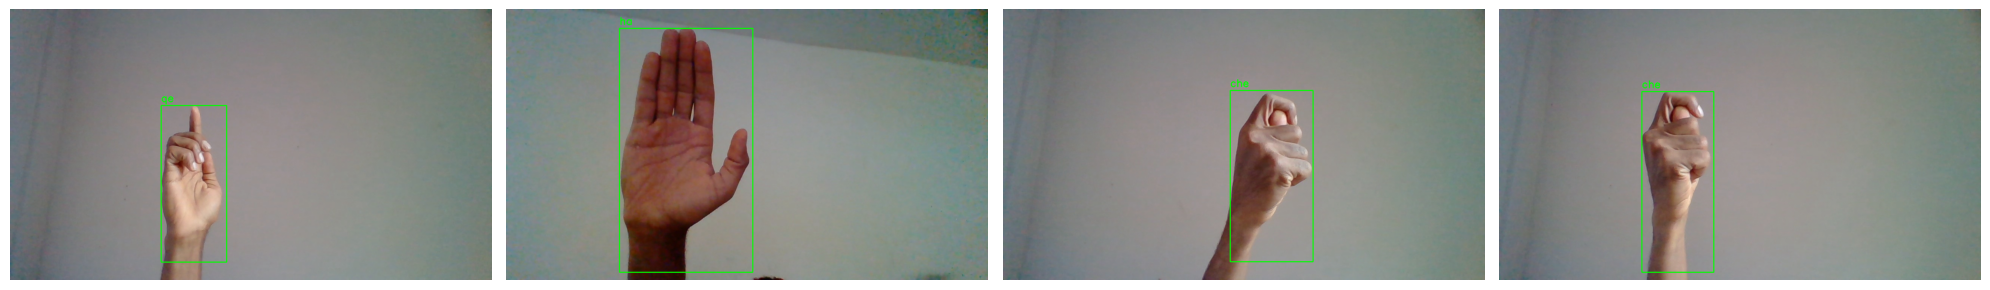

In [6]:
from __future__ import annotations
import cv2
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

image_path = "Amharic_Sign_Language/merged_dataset"
annotations = "Amharic_Sign_Language/merged_label.csv"
dataset_path = "Amharic_Sign_Language/merged_dataset"  

def visualize_image(ax, image_path, annotations):
    img = cv2.imread(image_path)
    for i, row in annotations.iterrows():
        x_min, y_min, x_max, y_max = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])
        label = row['class']
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        cv2.putText(img, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.axis('off')

# Load annotations
data_label = pd.read_csv(annotations)

# Visualizing 4 random images 
random_img = data_label['filename'].sample(n=4, random_state=1)

# Create subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5))  

for ax, img_path in zip(axs, random_img):
    img_annotations = data_label[data_label['filename'] == img_path]
    visualize_image(ax, os.path.join(dataset_path, img_path), img_annotations)

plt.tight_layout()
plt.show()


### Explore Preprocessing Details
#### Objective:
Understand the preprocessing steps mentioned (frame extraction, resizing, feature extraction).
#### Action:
- Image Dimensions: Check the resolution of images to confirm resizing consistency.
- Feature Extraction: If pre-extracted features are included (e.g., in TFRecord), inspect their format (e.g., keypoint data, embeddings).

In [7]:
# checking the dimension of the image

print(f'The dimesion of the images are consistent with width={ASL_label['width'].unique()} and height={ASL_label['height'].unique()}')
ASL_label[['width', 'height']].describe()


The dimesion of the images are consistent with width=[1280] and height=[720]


,width,height
count,2161.0,2161.0
mean,1280.0,720.0
std,0.0,0.0
min,1280.0,720.0
25%,1280.0,720.0
50%,1280.0,720.0
75%,1280.0,720.0
max,1280.0,720.0


### Check for Data Quality Issues
#### Objective:
Identify missing data, outliers, or inconsistencies.
Action:
#### Missing Values:
Check for null values in the CSV (e.g., missing labels or coordinates).
#### Invalid Bounding Boxes: Ensure x_min < x_max, y_min < y_max, and coordinates are within image dimensions.
Duplicate Images: Check for duplicate image paths or identical annotations.

In [8]:
# Missing values
print(f'Number of null data in train dataset{ASL_label.isnull().sum()}')


# Invalid bounding boxes
invalid_boxes = ASL_label[(ASL_label['xmin'] >= ASL_label['xmax']) | (ASL_label['ymin'] >= ASL_label['ymax'])]

print(f"Invalid bounding boxes: {len(invalid_boxes)}")

# Duplicate images
duplicates_train = ASL_label['filename'].duplicated().sum()

print(f"Duplicate images: {duplicates_train}")


Number of null data in train datasetindex       0
filename    0
width       0
height      0
class       0
xmin        0
ymin        0
xmax        0
ymax        0
dtype: int64
Invalid bounding boxes: 0
Duplicate images: 0


There is no images with missing annotations or invalid bounding boxes.
There is no duplicate image as well. we have a good dataset.

### Analyze Temporal/Spatial Patterns
#### Objective:
Explore patterns in spatial arrangement of gestures.


In [9]:
import plotly.express as px

ASL_label['center_x'] = (ASL_label['xmin'] + ASL_label['xmax']) / 2
ASL_label['center_y'] = (ASL_label['ymin'] + ASL_label['ymax']) / 2

px.scatter(data_frame=ASL_label,
           x='center_x',
           y='center_y',
           
           width=800,
           height=600)


The scatter plot shows that the bounding box centers are well-dispersed across the image area, with a relatively uniform spread along both the x and y axes. This indicates a balanced spatial distribution of the Amharic letters within the dataset, which helps reduce positional bias and supports more effective model generalization.


### Assess Dataset Suitability for Machine Learning
#### Objective:
Evaluate if the dataset is ready for training model.
#### Action:
Class Balance: Revisit class distribution to assess if augmentation or rebalancing is needed.
#### Annotation Format:
Confirm XML/CSV annotations are compatible with frameworks like TensorFlow or PyTorch.
#### Data Splits:
Check if train/validation/test splits are provided or need to be created.

In [10]:
from sklearn.model_selection import train_test_split

#  split the data into training and temp (validation + test)
train_label, temp = train_test_split(ASL_label, test_size=0.4, random_state=42)

# split the temp into validation and test
val_label, test_label = train_test_split(temp, test_size=0.5, random_state=42)

Feature Engineering

Feature engineering is a crucial step in preparing data for machine learning models. It involves creating new features or transforming existing ones to improve model performance. Here’s a breakdown of the process and rationale behind different techniques:

1. Image Resizing
Process: Standardizing all images to a fixed size (e.g., 128x128 pixels).
Rationale: Most machine learning models require input data to have consistent dimensions. Resizing helps ensure that all images can be processed uniformly.
2. Normalization
Process: Scaling pixel values to a range (typically 0 to 1) by dividing by 255 (the maximum pixel value).
Rationale: Normalization helps the model converge faster during training. It ensures that the features have similar ranges, which can improve the stability and performance of the learning algorithm.
3. Data Augmentation
Process: Applying random transformations to the training images, such as rotation, flipping, zooming, or shifting.
Rationale: Augmentation increases the diversity of the training data, which helps prevent overfitting and improves the model's ability to generalize to new, unseen data.
4. Color Space Transformation
Process: Converting images to different color spaces (e.g., from RGB to grayscale or HSV).
Rationale: Depending on the task, certain color spaces may highlight important features better than others. For instance, grayscale reduces complexity without losing essential information for many tasks.
5. Feature Extraction Using Pre-trained Models
Process: Utilizing models like VGG16, ResNet, etc., to extract features from images instead of using raw pixel values.
Rationale: Pre-trained models have learned rich feature representations from large datasets. Using these can significantly enhance the model's performance, especially when the dataset is small.
6. Bounding Box Coordinates (if applicable)
Process: Including the bounding box coordinates for objects within the images.
Rationale: If your task involves object detection or localization, these coordinates can provide valuable spatial information about the objects of interest.

In [11]:
import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator



# Define the target size for resizing
target_size = (128, 128)  # Example size

# Function to preprocess images
def preprocess_images(image_folder, labels):
    images = []
    classes = []

    for index, row in labels.iterrows():
        filename = row['filename']
        class_label = row['class']

        # Load the image
        image_path = os.path.join(image_folder, filename)

        # checking if the image exists
        if os.path.exists(image_path):
            image = cv2.imread(image_path)

            # Resize the image
            image = cv2.resize(image, target_size)

            # Normalize the image (scale pixel values to [0, 1])
            image = image / 255.0

            # Append to lists
            images.append(image)
            classes.append(class_label)

    return np.array(images), np.array(classes)

# Preprocess the images
train_images, train_classes = preprocess_images('Amharic_Sign_Language/merged_dataset/', train_label)
val_images, val_classes = preprocess_images('Amharic_Sign_Language/merged_dataset/', val_label)
test_images, test_classes = preprocess_images('Amharic_Sign_Language/merged_dataset/', test_label)



# Check the shape of the processed images
print("Shape of training images:", train_images.shape)

# Data Augmentation
data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


# Example of using the generator on a batch of images
augmented_images = data_gen.flow(train_images, train_classes, batch_size=32)

# Check the shape of the augmented images
augmented_batch = next(augmented_images)
print("Shape of augmented images:", augmented_batch[0].shape)  # Access the first element for images



Shape of training images: (1295, 128, 128, 3)
Shape of augmented images: (32, 128, 128, 3)


In [15]:
train_label.shape

(1296, 11)

### Encode each classes 

In [16]:
from sklearn.preprocessing import LabelEncoder

# Create the encoder and fit it on all labels
label_encoder = LabelEncoder()
label_encoder.fit(train_classes)  # Fit only on training to avoid data leakage

# Transform the labels
train_classes_encoded = label_encoder.transform(train_classes)
val_classes_encoded = label_encoder.transform(val_classes)
test_classes_encoded = label_encoder.transform(test_classes)


**Model Exploration**

We have selected a convolutional neural network (CNN), due to its effectiveness in handling spatial data and its ability to capture complex patterns. 

- The CNN have 4 convolutionary layer. The output from the final convolutionary layer well be feed into a fully connected ANN. 
- We'll use rectified linear unit(ReLU) activation function for the convulutionary layer; default activation function.
- Moreover, we'll use a softmax activation function for the final fully connected-layer because of our classes are more than two (10 classes).
-The default Adam optimizer well be used for model optimization.

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the CNN model
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential()

    # Convolutional Layer 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    # Convolutional Layer 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Convolutional Layer 3
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten the output
    model.add(layers.Flatten())

    # Fully Connected Layer
    model.add(layers.Dense(128, activation='relu'))

    # Output Layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

# Define input shape and number of classes
input_shape = (128, 128, 3)  # Image size and channels
num_classes = len(np.unique(train_classes))  # Number of unique classes

# Create the model
cnn_model = create_cnn_model(input_shape, num_classes)

# Compile the model
cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Summary of the model
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,930 (12.61 MB)

 Trainable params: 3,305,930 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

2. Model Training
The model was trained with 30 epochs with varying performance across the training and validation datasets. Key details include:

Hyperparameters:

Learning Rate: A suitable learning rate was chosen to balance convergence speed and stability (Default Adam optimizer learning rate = 0.001).
Batch Size: The batch size (32) was set to optimize memory usage and training speed.
Training Process:

## Model Training with Validation

**Early Stopping-** monitors a metric (usually validation loss or accuracy) and stops training when it stops improving, helping prevent overfitting and saving time.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# early stopping to prevent overfitting

# Create the callback
early_stopping = EarlyStopping(
    monitor='val_loss',     
    patience=3,             
    restore_best_weights=True  
)


In [20]:
# Train the model using augmented images and validate on clean validation data
history = cnn_model.fit(
    data_gen.flow(train_images, train_classes_encoded, batch_size=32),
    epochs=50,
    validation_data=(val_images, val_classes_encoded),
    callbacks=[early_stopping]
)



c:\Users\sinel\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 19s 378ms/step - accuracy: 0.1165 - loss: 2.3071 - val_accuracy: 0.3958 - val_loss: 1.4526
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 392ms/step - accuracy: 0.4209 - loss: 1.4575 - val_accuracy: 0.5069 - val_loss: 1.2139
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 384ms/step - accuracy: 0.5369 - loss: 1.1052 - val_accuracy: 0.3681 - val_loss: 1.4734
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 384ms/step - accuracy: 0.5576 - loss: 1.0796 - val_accuracy: 0.7593 - val_loss: 0.7154
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 389ms/step - accuracy: 0.7273 - loss: 0.7152 - val_accuracy: 0.7407 - val_loss: 0.4856
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 403ms/step - accuracy: 0.7388 - loss: 0.6823 - val_accuracy: 0.7037 - val_loss: 0.5866
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 388ms/step - accuracy: 0.7682 - loss: 0.5725 - val_accuracy: 0.8032 - val_loss: 0.4439
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 378ms/step - accuracy: 0.8106 - loss: 0.4876 - val_accu

**Predict on Test Set**

In [1]:
0.1709*100

17.09

In [21]:
# Get predictions for test set
predictions = cnn_model.predict(test_images)

# Convert probabilities to predicted class indices
predicted_classes = np.argmax(predictions, axis=1)
predicted_classes.shape

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


(433,)

## Model Evaluation

To assess the model's performance, various metrics were used:


**Evaluate on the Test Set**

After training, evaluate the model on the test set to get accuracy and loss.

In [ ]:
# model evaluation
test_loss, test_accuracy = cnn_model.evaluate(test_images, test_classes_encoded)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9954 - loss: 0.0610
Test Accuracy: 0.9954
Test Loss: 0.0598


In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px


# Decode labels back to original strings (if needed)
predicted_labels = label_encoder.inverse_transform(predicted_classes)
true_labels = label_encoder.inverse_transform(test_classes_encoded)


# Print classification report
print(classification_report(true_labels, predicted_labels))

# #  Display confusion matrix



cm = confusion_matrix(true_labels, predicted_labels)

fig = px.imshow(cm,
                color_continuous_scale='viridis',
                text_auto=True, 
                width=800,
                height=500)

fig.update_layout(title='Confussion Matrix')
fig.show()


              precision    recall  f1-score   support

         che       1.00      0.93      0.96        29
         gne       1.00      1.00      1.00        49
          ha       1.00      1.00      1.00        50
          he       1.00      1.00      1.00        50
         hhe       1.00      1.00      1.00        41
          ke       1.00      1.00      1.00        42
          le       1.00      1.00      1.00        43
          me       1.00      1.00      1.00        37
          ne       1.00      1.00      1.00        46
          qe       0.96      1.00      0.98        46

    accuracy                           1.00       433
   macro avg       1.00      0.99      0.99       433
weighted avg       1.00      1.00      1.00       433



### Training, Validation Accuracy and Losses

In [24]:
import plotly.graph_objects as go

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)


fig = make_subplots(rows=2, cols=2, subplot_titles=['Training and Validation Accuracy', 'Training and Validation Loss'])

fig.add_trace(go.Scatter(x=list(epochs),y=acc, mode='lines+markers', name='Training Accuracy'), row=1, col=1)
fig.add_trace(go.Scatter(x=list(epochs),y=loss, mode='lines+markers', name='Training Loss'), row=1, col=2)
fig.add_trace(go.Scatter(x=list(epochs),y=val_acc, mode='lines+markers', name='Validation Accuracy'), row=2, col=1)
fig.add_trace(go.Scatter(x=list(epochs),y=val_loss, mode='lines+markers', name='Validation Loss'), row=2, col=2)


fig.update_layout(
    xaxis3_title='Epochs',
    xaxis4_title='Epochs',
    yaxis_title = 'Accuracy',
    yaxis3_title = 'Accuracy'

)
fig.show()

Final Validation Accuracy: The model achieved a validation accuracy of approximately 98.84% on unseen data, demonstrating its generalization capability.

Loss Metrics: The final validation loss was 0.0711, indicating a relatively low error rate on the validation set.


**The ROC-AUC Curve**

In [31]:
import plotly.graph_objs as go
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# One-hot encode true labels
n_classes = len(label_encoder.classes_)
y_true = label_binarize(test_classes_encoded, classes=range(n_classes))

# Predicted probabilities
y_score = cnn_model.predict(test_images)

# Create a Plotly figure
fig = go.Figure()

# Generate ROC curve for each class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)

    fig.add_trace(go.Scatter(
        x=fpr,
        y=tpr,
        mode='lines',
        name=f'Class {label_encoder.classes_[i]} (AUC = {roc_auc:.2f})'

    ))

# Add random guess diagonal
fig.add_trace(go.Scatter(
    x=[0, 1],
    y=[0, 1],
    mode='lines',
    line=dict(dash='dash'),
    name='Random Chance'
))

# Customize layout
fig.update_layout(
    title='Multi-class ROC Curve',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    xaxis=dict(range=[0, 1]),
    yaxis=dict(range=[0, 1]),
    legend=dict(x=0.6, y=0.05),
    template='plotly_white',
    width=800,
    height= 500
)

fig.show()


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


**Save the Model**

In [32]:
cnn_model.save("asl_cnn_model.h5")

**Loading the Saved Model**

In [ ]:
# loading the model
from tensorflow.keras.model import load_model

model = load_model('asl_cnn_model.h5')

test_prediction = model.predict(test_images)